In [30]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import seaborn as sns
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [31]:
table = read_csv('/Users/davidguzman/Documents/GitHub/BachelorThesis/csvs/NNdata14_20.csv')
table.head()

,Date,IDStation,NameStation,Ammonia,Arsenic,Benzo_a_pyrene,Cadmium,Lead,Nikel,NO,...,IDStation.2,NameStation.1,Wind_speed,Wind_direction,Temperature,Relative_humidity,Global_radiation,Wind_speed_max,Wind_direction_max,Rainfall
0,2014-01-01T00:00:00Z,681,Moggio Loc Penscei,0.0,NaN,0.1,NaN,NaN,NaN,NaN,...,111,Cassina Valsassina Moggio,0.443554,99.0,-0.334965,45.545455,58.097902,1.805594,143.0,0.0
1,2014-01-02T00:00:00Z,681,Moggio Loc Penscei,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,111,Cassina Valsassina Moggio,0.355915,105.0,-0.486111,83.944444,0.000000,1.767361,153.0,7.8
2,2014-01-03T00:00:00Z,681,Moggio Loc Penscei,0.0,1.1,NaN,0.0,1.1,4.2,NaN,...,111,Cassina Valsassina Moggio,0.207631,120.0,2.220588,87.042254,30.514085,1.558451,152.0,0.0
3,2014-01-04T00:00:00Z,681,Moggio Loc Penscei,0.0,NaN,0.1,NaN,NaN,NaN,NaN,...,111,Cassina Valsassina Moggio,1.024926,175.0,2.137063,89.349650,0.202797,3.816783,164.0,35.8
4,2014-01-05T00:00:00Z,681,Moggio Loc Penscei,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,111,Cassina Valsassina Moggio,0.666721,94.0,2.416084,86.055944,10.951049,2.797203,136.0,25.0


In [32]:
#Moggio = table.loc[table.loc[:,"NameStation"]=="Moggio",:]
#PM 2.5 were removed
Moggio = table.loc[:,["Date","PM10","Ammonia","Ozone","Wind_speed","Wind_direction","Temperature","Rainfall","Relative_humidity"]]
Moggio = Moggio.dropna(how="any")
Moggio = Moggio.reset_index()
Moggio = Moggio.iloc[:-365,:] # we train not using 2020, for now
Moggio.head()


,index,Date,PM10,Ammonia,Ozone,Wind_speed,Wind_direction,Temperature,Rainfall,Relative_humidity
0,0,2014-01-01T00:00:00Z,6.0,0.0,71.9,0.443554,99.0,-0.334965,0.0,45.545455
1,1,2014-01-02T00:00:00Z,6.0,0.0,76.8,0.355915,105.0,-0.486111,7.8,83.944444
2,2,2014-01-03T00:00:00Z,11.0,0.0,66.6,0.207631,120.0,2.220588,0.0,87.042254
3,3,2014-01-04T00:00:00Z,6.0,0.0,77.2,1.024926,175.0,2.137063,35.8,89.349650
4,4,2014-01-05T00:00:00Z,3.0,0.0,66.2,0.666721,94.0,2.416084,25.0,86.055944


In [33]:
# sns.lineplot(x='Date', y='PM25', data=Moggio)

##Convert series to supervised learning
### Activation function = tanh and logistic (s curve)

###Conversion Function

In [34]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

### Conversion of Moggio

In [35]:
values = Moggio.iloc[:,2:].values
# ensure all data is float
values = values.astype('float32') #cast in float 32 bit per evitare problemi
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5 #Memoria della NN
reframed = series_to_supervised(scaled, n_days, 5) # info of the past 5 days to determine next (5) day
# drop columns we don't want to predict (we therefore keep Ammonia)
#reframed.drop(reframed.columns[[31,32,33,34,35]], axis=1, inplace=True)

reframed.head()

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var1(t-4),var2(t-4),...,var7(t+3),var8(t+3),var1(t+4),var2(t+4),var3(t+4),var4(t+4),var5(t+4),var6(t+4),var7(t+4),var8(t+4)
5,0.066667,0.0,0.265198,0.161974,0.275000,0.286365,0.000000,0.376259,0.066667,0.0,...,0.000000,0.807349,0.133333,0.0,0.244301,0.140276,0.738889,0.409331,0.000000,0.781125
6,0.066667,0.0,0.283815,0.129068,0.291667,0.282413,0.035199,0.816993,0.122222,0.0,...,0.000000,0.781125,0.122222,0.0,0.245441,0.067419,0.019444,0.387761,0.000000,0.814363
7,0.122222,0.0,0.245061,0.073391,0.333333,0.353183,0.000000,0.852549,0.066667,0.0,...,0.000000,0.814363,0.066667,0.0,0.250000,0.022801,0.188889,0.425800,0.000000,0.505500
8,0.066667,0.0,0.285334,0.380262,0.486111,0.350999,0.161552,0.879033,0.033333,0.0,...,0.000000,0.505500,0.177778,0.0,0.262918,0.121736,0.694444,0.335977,0.008123,0.652479
9,0.033333,0.0,0.243541,0.245766,0.261111,0.358295,0.112816,0.841229,0.022222,0.0,...,0.008123,0.652479,0.066667,0.0,0.183511,0.042392,0.833333,0.294106,0.166967,0.894468


In [36]:
# split into train and test sets
values = reframed.values
n_features = 8 # number of variables, including the one to be predicted
n_train_days = 1312 # we train using only the first year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years 
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -8*5:] #!!! -30 because we are predicting all 6 features for the the future 5 days (-6*5=30)
test_X, test_y = test[:, :n_obs], test[:, -8*5:]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
# reshape from 2D to 3D
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1312, 40) 1312 (1312, 40)
(1312, 5, 8) (1312, 40) (364, 5, 8) (364, 40)


# Modeling and training

In [37]:
from tensorflow import keras
import keras_tuner as kt

In [38]:
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        #hp_units = hp.Int('units', min_value=10, max_value=60, step=10)
        hp_units = 50
        #hp_dropout = hp.Choice('dropout', values=[0.0, 0.25, 0.5, 0.75])
        hp_dropout = 0
        model = Sequential()
        model.add(LSTM(units = hp_units,return_sequences=True, dropout = hp_dropout, input_shape=(train_X.shape[1], train_X.shape[2])))
        for i in range(hp.Int('layers',1,1)):
            model.add(LSTM(units = hp_units, return_sequences=True))
        model.add(LSTM(units = hp_units, return_sequences=False))
        model.add(Dense(8*5))
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate))
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [16, 32, 64, 128]),
            **kwargs,
        )


In [39]:
tuner = kt.RandomSearch(
    MyHyperModel(),
    objective='val_loss',
    max_trials=1,
    executions_per_trial =1,
    overwrite=True,
    directory = 'dir',
    project_name = 'tune_hypermodel')
tuner.search_space_summary()

Search space summary
Default search space size: 2
layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 1, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [40]:
early_stopping = EarlyStopping(monitor='val_loss',patience=80)
tuner.search(train_X, train_y, epochs=700, validation_data=(test_X, test_y),shuffle=False, callbacks=[early_stopping])

Trial 1 Complete [00h 06m 20s]
val_loss: 0.1091277152299881

Best val_loss So Far: 0.1091277152299881
Total elapsed time: 00h 06m 20s
INFO:tensorflow:Oracle triggered exit


In [41]:
tuner.results_summary()

Results summary
Results in dir/tune_hypermodel
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
layers: 1
learning_rate: 0.0001
batch_size: 16
Score: 0.1091277152299881


In [42]:
model = tuner.get_best_models()[0]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 50)             11800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 40)                2040      
Total params: 54,240
Trainable params: 54,240
Non-trainable params: 0
_________________________________________________________________


## Predictions of the year 2019

#### Prediciton plots

prediction with 2020

In [43]:
#Moggio = table.loc[table.loc[:,"NameStation"]=="Moggio",:]
#PM 2.5 were removed
Moggio = table.loc[:,["Date","PM10","Ammonia","Ozone","Wind_speed","Wind_direction","Temperature","Rainfall","Relative_humidity"]]
Moggio = Moggio.dropna(how="any")
Moggio = Moggio.reset_index()
Moggio = Moggio.iloc[:,:] # this is the differrence!!!! we keep the 2020 data 
Moggio.head()
values = Moggio.iloc[:,2:].values

# ensure all data is float
values = values.astype('float32') #cast in float 32 bit per evitare problemi
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5 #Memoria della NN
reframed = series_to_supervised(scaled, n_days, 5) # info of the past 5 days to determine next (5) day
# drop columns we don't want to predict (we therefore keep Ammonia)
#reframed.drop(reframed.columns[[31,32,33,34,35]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
n_features = 8 # number of variables, including the one to be predicted
n_train_days = 1312 # we train using only the first year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years 
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -8*5:] #!!! -30 because we are predicting all 6 features for the the future 5 days (-6*5=30)
test_X, test_y = test[:, :n_obs], test[:, -8*5:]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
# reshape from 2D to 3D
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(1312, 40) 1312 (1312, 40)
(1312, 5, 8) (1312, 40) (729, 5, 8) (729, 40)


In [44]:
# make a prediction
yhat = model.predict(test_X)
#Convert from 3D to 2D
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))

2022-03-14 01:06:24.328338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-14 01:06:24.373424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-14 01:06:24.458798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-14 01:06:24.531223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [45]:
(yhat.shape[1])/8

5.0

In [46]:
# invert scaling

inv_yhat = []
inv_y = []
a = 0
b = 8
for x in range(int((yhat.shape[1])/8)):
  inv_yhat.append(scaler.inverse_transform(yhat[:,a:b]))
  inv_y.append(scaler.inverse_transform(test_y[:,a:b]))
  a = a + 8
  b = b + 8

In [47]:
len(inv_yhat)

5

In [48]:
# calculate RMSE taking into account all variables
for i in range(len(inv_yhat)):
  rmse = sqrt(mean_squared_error(inv_y[i], inv_yhat[i]))
  print('Test RMSE: %.3f' % rmse + ' at time step #' + str(i))

Test RMSE: 33.720 at time step #0
Test RMSE: 33.564 at time step #1
Test RMSE: 33.560 at time step #2
Test RMSE: 33.794 at time step #3
Test RMSE: 33.313 at time step #4


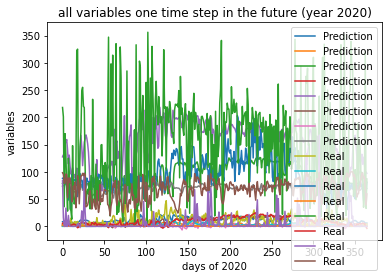

In [49]:
pyplot.plot(inv_yhat[0][-365:], label = 'Prediction')
pyplot.plot(inv_y[0][-365:], label = 'Real')
pyplot.legend()
pyplot.title("all variables one time step in the future (year 2020)")
pyplot.xlabel('days of 2020') 
pyplot.ylabel('variables') 
pyplot.show()

### PM10

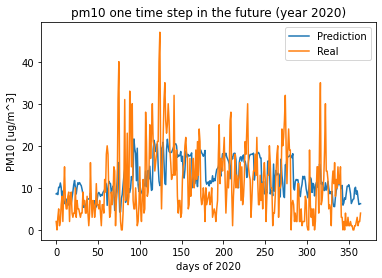

Test RMSE: 8.147


In [50]:
pred = inv_yhat[0][:,0][-365:]  # first brackets indicate the timestep counting from 5, second the variable, third the days to plot
real = inv_y[0][:,0][-365:]

pyplot.plot(pred, label = 'Prediction') 
pyplot.plot(real, label = 'Real')
pyplot.legend()
pyplot.title("pm10 one time step in the future (year 2020)")
pyplot.xlabel('days of 2020') 
pyplot.ylabel('PM10 [ug/m^3]') 
pyplot.show()

rmse = sqrt(mean_squared_error(pred, real))
print('Test RMSE: %.3f' % rmse)

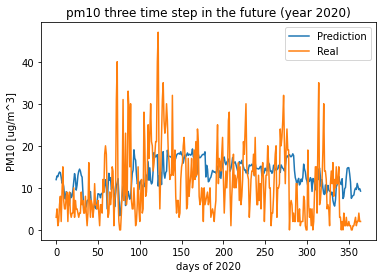

Test RMSE: 8.476


In [51]:
pred = inv_yhat[2][:,0][-365:]  # first brackets indicate the timestep counting from 5, second the variable, third the days to plot
real = inv_y[2][:,0][-365:]

pyplot.plot(pred, label = 'Prediction') 
pyplot.plot(real, label = 'Real')
pyplot.legend()
pyplot.title("pm10 three time step in the future (year 2020)")
pyplot.xlabel('days of 2020') 
pyplot.ylabel('PM10 [ug/m^3]') 
pyplot.show()

rmse = sqrt(mean_squared_error(pred, real))
print('Test RMSE: %.3f' % rmse)

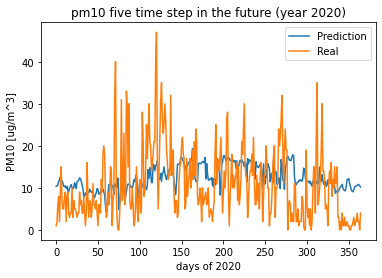

Test RMSE: 8.235


In [52]:
pred = inv_yhat[4][:,0][-365:]  # first brackets indicate the timestep counting from 5, second the variable, third the days to plot
real = inv_y[4][:,0][-365:]

pyplot.plot(pred, label = 'Prediction') 
pyplot.plot(real, label = 'Real')
pyplot.legend()
pyplot.title("pm10 five time step in the future (year 2020)")
pyplot.xlabel('days of 2020') 
pyplot.ylabel('PM10 [ug/m^3]') 
pyplot.show()


rmse = sqrt(mean_squared_error(pred, real))
print('Test RMSE: %.3f' % rmse)

### Ammonia

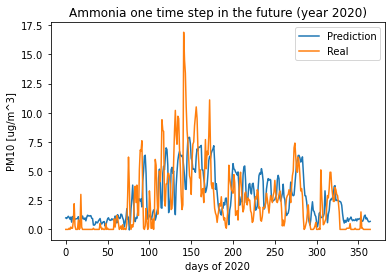

Test RMSE: 2.373


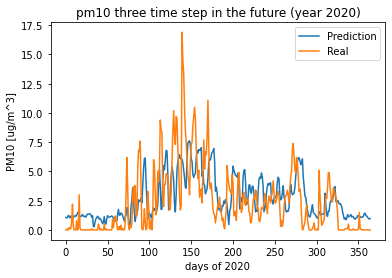

Test RMSE: 2.412


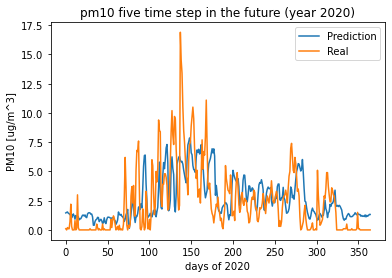

Test RMSE: 2.421


In [53]:
pred = inv_yhat[0][:,1][-365:]  # first brackets indicate the timestep counting from 5, second the variable, third the days to plot
real = inv_y[0][:,1][-365:]

pyplot.plot(pred, label = 'Prediction') 
pyplot.plot(real, label = 'Real')
pyplot.legend()
pyplot.title("Ammonia one time step in the future (year 2020)")
pyplot.xlabel('days of 2020') 
pyplot.ylabel('PM10 [ug/m^3]') 
pyplot.show()

rmse = sqrt(mean_squared_error(pred, real))
print('Test RMSE: %.3f' % rmse)

pred = inv_yhat[2][:,1][-365:]  # first brackets indicate the timestep counting from 5, second the variable, third the days to plot
real = inv_y[2][:,1][-365:]

pyplot.plot(pred, label = 'Prediction') 
pyplot.plot(real, label = 'Real')
pyplot.legend()
pyplot.title("pm10 three time step in the future (year 2020)")
pyplot.xlabel('days of 2020') 
pyplot.ylabel('PM10 [ug/m^3]') 
pyplot.show()

rmse = sqrt(mean_squared_error(pred, real))
print('Test RMSE: %.3f' % rmse)

pred = inv_yhat[4][:,1][-365:]  # first brackets indicate the timestep counting from 5, second the variable, third the days to plot
real = inv_y[4][:,1][-365:]

pyplot.plot(pred, label = 'Prediction') 
pyplot.plot(real, label = 'Real')
pyplot.legend()
pyplot.title("pm10 five time step in the future (year 2020)")
pyplot.xlabel('days of 2020') 
pyplot.ylabel('PM10 [ug/m^3]') 
pyplot.show()


rmse = sqrt(mean_squared_error(pred, real))
print('Test RMSE: %.3f' % rmse)

# LIME

In [54]:
from lime import lime_tabular

In [55]:
test_X.shape

(729, 40)

In [56]:
explainer = lime_tabular.RecurrentTabularExplainer(test_X, feature_names=["PM10","Ammonia","Wind_speed","Wind_direction","Temperature","Rainfall"], mode='regression')

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
exp = explainer.explain_instance(test_X[50], model.predict, num_features=6,labels=(1,))
exp.show_in_notebook()

In [ ]:
exp = explainer.explain_instance(test_X[49], model.predict, num_features=6,labels=(1,))
exp.show_in_notebook()

In [ ]:
exp = explainer.explain_instance(test_X[75], model.predict, num_features=6,labels=(1,))
exp.show_in_notebook()

In [ ]:
test_X[1]

In [ ]:
exp.as_list()